# Importing The Modules

In [26]:
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
import numpy as np 
import pandas as pd 
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from keras.callbacks import EarlyStopping 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

from tensorflow.keras import models, layers
from tensorflow.keras.applications import ResNet50, VGG19, InceptionV3

# Data Preparation

In [34]:
def data_prep(parasitized,uninfected):

    parasitized= [r"C:\Users\Kalyan\Desktop\OpenHealth\Notebook_Experiments\Data\cell_images\Parasitized" + '/' +  parasitize for parasitize in parasitized]
    uninfected= [r"C:\Users\Kalyan\Desktop\OpenHealth\Notebook_Experiments\Data\cell_images\Uninfected" + '/' +  uninfect for uninfect in uninfected]

    labels = len(parasitized)*['parasitized'] + len(uninfected)*['uninfected']
    data = parasitized + uninfected

    return pd.DataFrame({'Image_Path': data , 'Labels': labels})


df = data_prep(os.listdir(r'C:\Users\Kalyan\Desktop\OpenHealth\Notebook_Experiments\Data\cell_images\Parasitized'), os.listdir(r'C:\Users\Kalyan\Desktop\OpenHealth\Notebook_Experiments\Data\cell_images\Uninfected'))
df

,Image_Path,Labels
0,C:\Users\Kalyan\Desktop\OpenHealth\Notebook_Ex...,parasitized
1,C:\Users\Kalyan\Desktop\OpenHealth\Notebook_Ex...,parasitized
2,C:\Users\Kalyan\Desktop\OpenHealth\Notebook_Ex...,parasitized
3,C:\Users\Kalyan\Desktop\OpenHealth\Notebook_Ex...,parasitized
4,C:\Users\Kalyan\Desktop\OpenHealth\Notebook_Ex...,parasitized
...,...,...
27555,C:\Users\Kalyan\Desktop\OpenHealth\Notebook_Ex...,uninfected
27556,C:\Users\Kalyan\Desktop\OpenHealth\Notebook_Ex...,uninfected
27557,C:\Users\Kalyan\Desktop\OpenHealth\Notebook_Ex...,uninfected
27558,C:\Users\Kalyan\Desktop\OpenHealth\Notebook_Ex...,uninfected


Displaying 5 Parasitized Images: 



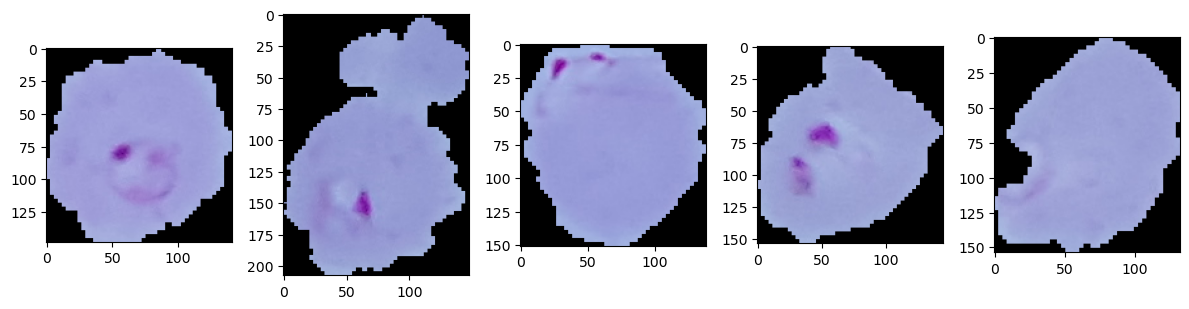


Displaying 5 Uninfected Images: 



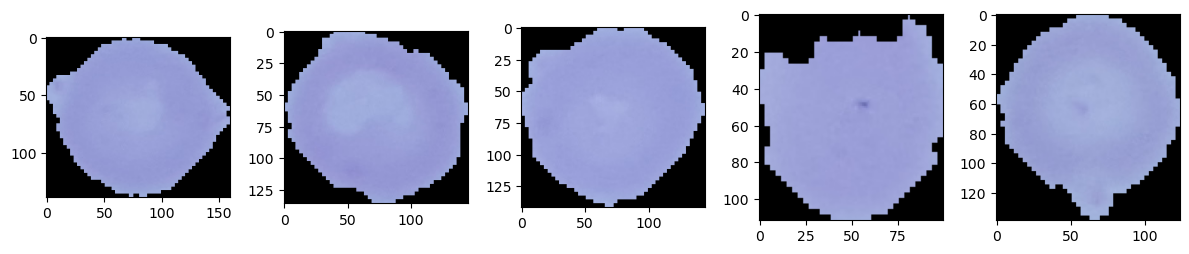

In [35]:
print("Displaying 5 Parasitized Images: ")
print()
plt.figure(figsize = (12,12))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = cv2.imread(df[df['Labels'] == 'parasitized']['Image_Path'][i])
    plt.imshow(img)
    plt.tight_layout()
plt.show()


print()
print("Displaying 5 Uninfected Images: ")
print()
plt.figure(figsize = (12,12))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = cv2.imread(df[df['Labels'] == 'uninfected']['Image_Path'].reset_index(drop=True)[i])
    plt.imshow(img)
    plt.tight_layout()
plt.show()


# Distribution Of Samples

Text(0.5, 1.0, 'Distribution of samples according to the categories')

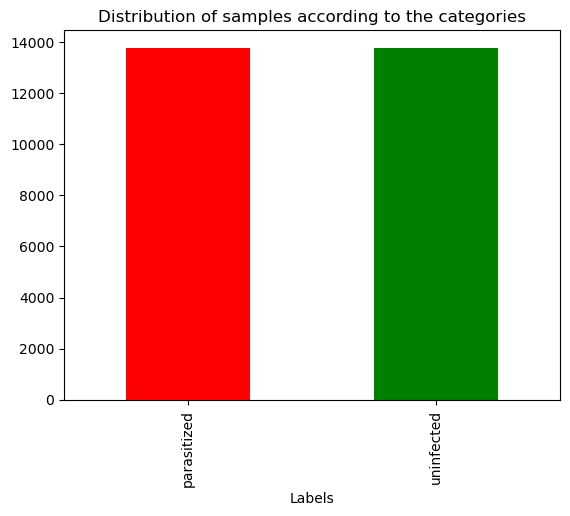

In [36]:
df['Labels'].value_counts().plot(kind = 'bar', color = ['red', 'green'])
plt.title('Distribution of samples according to the categories')

# Augmenting The Data

In [37]:

train, test = train_test_split(df, test_size = .20)

img_datagen = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest', validation_split=0.2)
                               
                               
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [38]:
def plot_loss_and_accuracy(mo_fit):
    accuracy = mo_fit.history['accuracy']
    loss = mo_fit.history['loss']
    validation_loss = mo_fit.history['val_loss']
    validation_accuracy = mo_fit.history['val_accuracy']



    plt.figure(figsize=(15, 7))
    plt.subplot(2, 2, 1)
    plt.plot(range(len(accuracy)), accuracy, label='Training Accuracy')
    plt.plot(range(len(accuracy)), validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='upper left')
    plt.title('Accuracy : Training Vs Validation ')



    plt.subplot(2, 2, 2)
    plt.plot(range(len(accuracy)), loss, label='Training Loss')
    plt.plot(range(len(accuracy)), validation_loss, label='Validation Loss')
    plt.title('Loss : Training Vs Validation ')
    plt.legend(loc='upper right')
    plt.show()


# Building CNN

Found 17637 validated image filenames belonging to 2 classes.
Found 1102 validated image filenames belonging to 2 classes.
Epoch 1/4
100/100 [==============================] - 34s 329ms/step - loss: 1.8950 - accuracy: 0.6110 - val_loss: 0.7102 - val_accuracy: 0.4940
Epoch 2/4
100/100 [==============================] - 25s 251ms/step - loss: 0.4994 - accuracy: 0.7860 - val_loss: 0.4442 - val_accuracy: 0.8060
Epoch 3/4
100/100 [==============================] - 26s 259ms/step - loss: 0.3370 - accuracy: 0.8740 - val_loss: 0.2722 - val_accuracy: 0.9070
Epoch 4/4
100/100 [==============================] - 25s 252ms/step - loss: 0.2822 - accuracy: 0.9150 - val_loss: 0.2238 - val_accuracy: 0.9230


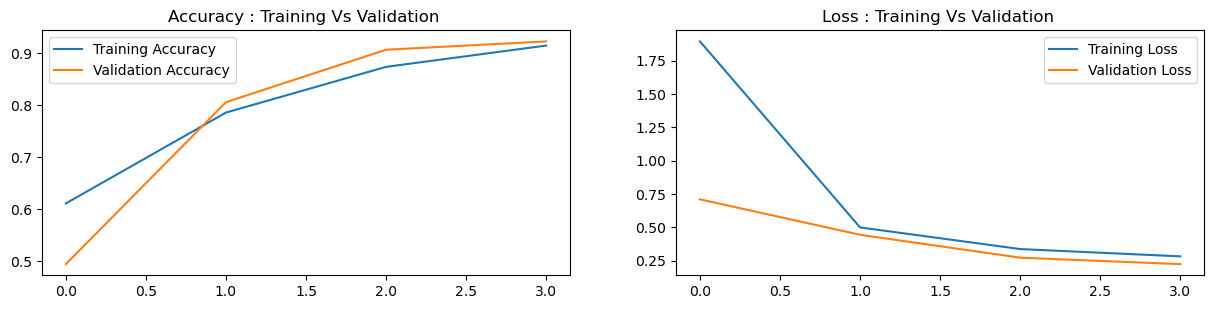

In [39]:
def cnn_model(df, train, test, my_callbacks):
    
    x_train =  img_datagen.flow_from_dataframe(dataframe = train,  x_col='Image_Path', y_col='Labels',  class_mode='binary',target_size=(134,134), shuffle=False, batch_size=10, seed=10, subset='training')
    x_test = img_datagen.flow_from_dataframe(dataframe = test,  x_col='Image_Path', y_col='Labels',class_mode='binary',  target_size=(134,134), shuffle=False, batch_size=10, seed=10, subset='validation')
    
    model = tf.keras.Sequential(
        [
          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(130,130,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(130,130,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(130,130,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(130,130,3) ,filters=64, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(rate=0.5),
          tf.keras.layers.Dense(1, activation='sigmoid')
  ])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

    model_history = model.fit_generator(generator = x_train, 
                   steps_per_epoch = 100,
                   epochs = 4 ,
                   validation_data = x_test,
                   validation_steps = 100, callbacks=my_callbacks)
    
    return model_history

    
plot_loss_and_accuracy(cnn_model(df, train, test, my_callbacks))


# Building ResNet50

Found 17637 validated image filenames belonging to 2 classes.
Found 1102 validated image filenames belonging to 2 classes.
Epoch 1/4
100/100 [==============================] - 212s 2s/step - loss: 0.6070 - accuracy: 0.8050 - val_loss: 2.3098 - val_accuracy: 0.8240
Epoch 2/4
100/100 [==============================] - 154s 2s/step - loss: 0.5421 - accuracy: 0.8580 - val_loss: 1.9947 - val_accuracy: 0.8460
Epoch 3/4
100/100 [==============================] - 154s 2s/step - loss: 0.4289 - accuracy: 0.8570 - val_loss: 1.8742 - val_accuracy: 0.9040
Epoch 4/4
100/100 [==============================] - 152s 2s/step - loss: 0.3216 - accuracy: 0.9020 - val_loss: 1.1654 - val_accuracy: 0.8980


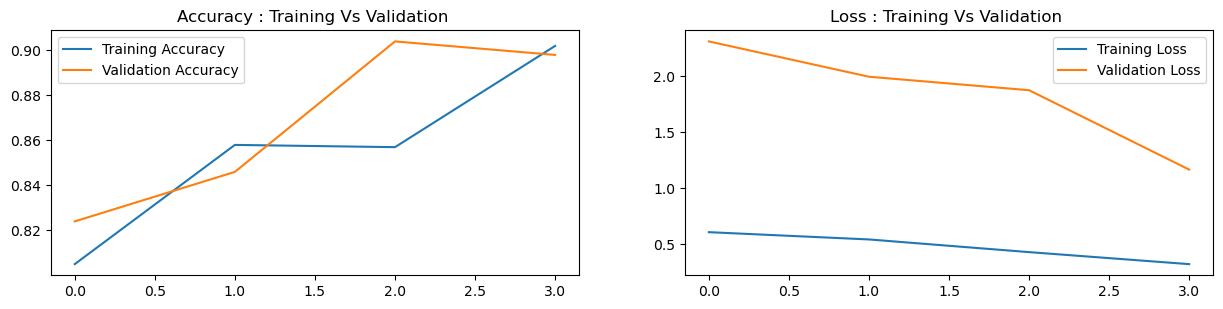

In [40]:
def resnet_model(df, train, test, my_callbacks):
    x_train =  img_datagen.flow_from_dataframe(dataframe = train,  x_col='Image_Path', y_col='Labels',  class_mode='binary',target_size=(64,64), shuffle=False, batch_size=10, seed=10, subset='training')
    x_test = img_datagen.flow_from_dataframe(dataframe = test,  x_col='Image_Path', y_col='Labels',class_mode='binary',  target_size=(64,64), shuffle=False, batch_size=10, seed=10, subset='validation')
    
    resnet_model=ResNet50(weights='imagenet',include_top=False,input_shape=(64,64,3))
    model=Sequential()
    model.add(resnet_model)
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-4),loss='binary_crossentropy',metrics=['accuracy'])
    
    
    model_history = model.fit(
    x_train,
    steps_per_epoch=100,
    validation_data=x_test,
    validation_steps=100,
    epochs = 4, callbacks=my_callbacks)
    
    
    return model_history
    
plot_loss_and_accuracy(resnet_model(df, train, test, my_callbacks))

# Building VGG 19

In [ ]:
def vgg19_model(df, train, test, my_callbacks):
    x_train =  img_datagen.flow_from_dataframe(dataframe = train,  x_col='Image_Path', y_col='Labels',  class_mode='binary',target_size=(224,224), shuffle=False, batch_size=10, seed=10, subset='training')
    x_test = img_datagen.flow_from_dataframe(dataframe = test,  x_col='Image_Path', y_col='Labels',class_mode='binary',  target_size=(224,224), shuffle=False, batch_size=10, seed=10, subset='validation')
    
    vgg19_model = VGG19(input_shape=(224,224,3), weights='imagenet',include_top=False)
    model=Sequential()
    model.add(vgg19_model)
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-4),loss='binary_crossentropy',metrics=['accuracy'])
    
    model_history = model.fit(
    x_train,
    steps_per_epoch=100,
    validation_data=x_test,
    validation_steps=100, 
    epochs = 4 , callbacks=my_callbacks)
    
    return model_history
    
plot_loss_and_accuracy(vgg19_model(df, train, test, my_callbacks))

Found 17637 validated image filenames belonging to 2 classes.
Found 1102 validated image filenames belonging to 2 classes.
80134624/80134624 [==============================] - 29s 0us/step
Epoch 1/4
100/100 [==============================] - 749s 7s/step - loss: 1.0231 - accuracy: 0.6410 - val_loss: 0.4435 - val_accuracy: 0.9270
Epoch 2/4
100/100 [==============================] - 712s 7s/step - loss: 0.4187 - accuracy: 0.9100 - val_loss: 0.3220 - val_accuracy: 0.9000
Epoch 3/4
 75/100 [=====================>........] - ETA: 2:36 - loss: 0.3376 - accuracy: 0.9147

# Building InceptionV3

Found 17637 validated image filenames belonging to 2 classes.
Found 1102 validated image filenames belonging to 2 classes.
Epoch 1/4
100/100 [==============================] - 2363s 24s/step - loss: 1.6749 - accuracy: 0.5481 - val_loss: 0.6948 - val_accuracy: 0.4930
Epoch 2/4
100/100 [==============================] - 2372s 24s/step - loss: 0.7275 - accuracy: 0.4914 - val_loss: 0.6936 - val_accuracy: 0.4960
Epoch 3/4
100/100 [==============================] - 2366s 24s/step - loss: 0.6930 - accuracy: 0.5037 - val_loss: 0.6932 - val_accuracy: 0.4960
Epoch 4/4
100/100 [==============================] - 2371s 24s/step - loss: 0.6928 - accuracy: 0.5295 - val_loss: 0.6932 - val_accuracy: 0.4960


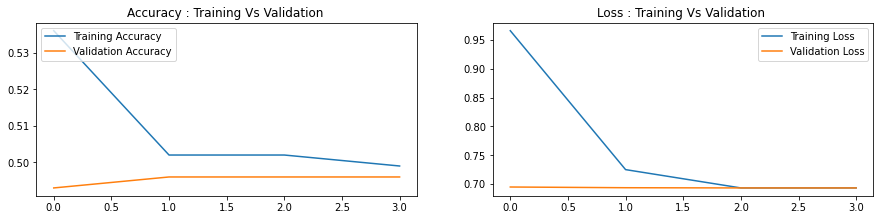

In [18]:
def inception_v3_model(df, train, test, my_callbacks):
    x_train =  img_datagen.flow_from_dataframe(dataframe = train,  x_col='Image_Path', y_col='Labels',  class_mode='binary',target_size=(299, 299), shuffle=False, batch_size=10, seed=10, subset='training')
    x_test = img_datagen.flow_from_dataframe(dataframe = test,  x_col='Image_Path', y_col='Labels',class_mode='binary',  target_size=(299, 299), shuffle=False, batch_size=10, seed=10, subset='validation')
    
    vgg19_model = VGG19(input_shape=(299, 299,3), weights='imagenet',include_top=False)
    model=Sequential()
    model.add(vgg19_model)
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-4),loss='binary_crossentropy',metrics=['accuracy'])
    
    model_history = model.fit(
    x_train,
    steps_per_epoch=100,
    validation_data=x_test,
    validation_steps=100, 
    epochs = 4 , callbacks=my_callbacks)
    
    return model_history
    
plot_loss_and_accuracy(inception_v3_model(df, train, test, my_callbacks))


# Conclusion

> **It can be seen VGG19 is performing the best in all the 4 models worked on here.**

> **InceptionV3 is performing the worst whereas the other two models are performing almost the same.**